# Getting familiar with TensorFlow

## Import libraries

In [7]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.12.0


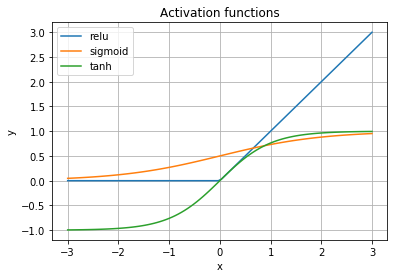

In [8]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [6]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.12.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. Here, we will use the standard 50,000 images for training and 10,000 images for test.

In [30]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'

## Define your layers

In [2]:
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def flatten(input):
    """
        - input: input tensors
    """
    return tf.contrib.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.contrib.layers.fully_connected(input,num_output,activation_fn=None)

def norm(input, is_training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    return tf.contrib.layers.norm(input,is_training)

## Sample convolutional neural network

In [3]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)   
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        self.flat = tf.contrib.layers.flatten(self.pool2)    
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            self.fc4 = fc(self.relu3,10)
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 500, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_op = optimizer.minimize(self.loss_op, global_step=global_step)        
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits=logits)) 

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                feed_dict = {self.X: X_,self.Y: Y_} 
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

        # Plot training curve                                                 
        # X: epoch, Y: training loss
        plt.figure()
        plt.title('Training Loss')
        plt.plot(range(self.num_epoch),losses[0::num_training // self.batch_size], '-o')
        plt.xlabel('epoch')
        plt.show()

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {self.X: X_,self.Y: Y_}
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 10.442, accuracy = 0.094
iteration (50): loss = 2.135, accuracy = 0.195
iteration (100): loss = 1.860, accuracy = 0.328
iteration (150): loss = 1.600, accuracy = 0.414
iteration (200): loss = 1.578, accuracy = 0.453
iteration (250): loss = 1.658, accuracy = 0.492
iteration (300): loss = 1.512, accuracy = 0.469
iteration (350): loss = 1.405, accuracy = 0.469
validation for epoch 0
-  epoch 0: validation accuracy = 0.497
train for epoch 1
iteration (400): loss = 1.456, accuracy = 0.469
iteration (450): loss = 1.399, accuracy = 0.539
iteration (500): loss = 1.444, accuracy = 0.461
iteration (550): loss = 1.145, accuracy = 0.609
iteration (600): loss = 1.426, accuracy = 0.484
iteration (650): loss = 1.410, accuracy = 0.508
iteration (700): loss = 1.254

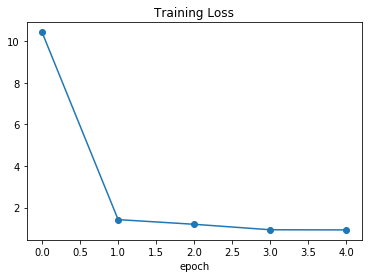

***** test accuracy: 0.595
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [12]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Implement a neural network again with GPU for fast training

using `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')`  

try list:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

In [31]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 10

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.elu1 = tf.nn.elu(self.conv1)          
            print('conv1 layer: ' + str(self.elu1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.elu1, 5, 1, 64)
            self.elu2 = tf.nn.elu(self.conv2)
            print('conv2 layer: ' + str(self.elu2.get_shape()))
        
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.elu2, 5, 1, 96)
            self.elu3 = tf.nn.elu(self.conv3)
            self.pool3 = max_pool(self.elu3, 3, 2)   
            print('conv3 layer: ' + str(self.pool3.get_shape()))
 
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.pool3, 3, 1, 128)
            self.elu4 = tf.nn.elu(self.conv4)
            self.pool4 = max_pool(self.elu4, 3, 2)   
            print('conv4 layer: ' + str(self.pool4.get_shape()))

        with tf.variable_scope('conv5'):
            self.conv5 = conv2d(self.pool4, 3, 1, 160)
            self.elu5 = tf.nn.elu(self.conv5)
            self.pool5 = max_pool(self.elu5, 3, 2)   
            print('conv5 layer: ' + str(self.pool5.get_shape()))

        self.flat = tf.contrib.layers.flatten(self.pool5)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.flat, 160)
            self.elu6 = tf.nn.elu(self.fc6)
            print('fc6 layer: ' + str(self.elu6.get_shape()))
            
        with tf.variable_scope('fc7'):
            self.fc7 = fc(self.elu6,10)
            print('fc7 layer: ' + str(self.fc7.get_shape()))
        return self.fc7

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        self.step = tf.placeholder(tf.int64)
        self.train_op = tf.train.AdamOptimizer(learning_rate=tf.train.exponential_decay(5e-4,self.step,500,0.96)).minimize(self.loss_op)
  
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits=logits)) 
   
    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_,self.Y: Y_,self.step: step} 
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        # Graph 1. X: epoch, Y: training loss
        plt.figure()
        plt.title('Training Loss')
        plt.plot(range(self.num_epoch),losses[0::num_training // self.batch_size], '-o')
        plt.xlabel('epoch')
        plt.show()

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            feed_dict = {self.X: X_,self.Y: Y_}
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter        

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
conv2 layer: (?, 32, 32, 64)
conv3 layer: (?, 16, 16, 96)
conv4 layer: (?, 8, 8, 128)
conv5 layer: (?, 4, 4, 160)
flat layer: (?, 2560)
fc6 layer: (?, 160)
fc7 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 4.101, accuracy = 0.086
iteration (50): loss = 1.541, accuracy = 0.422
iteration (100): loss = 1.553, accuracy = 0.383
iteration (150): loss = 1.368, accuracy = 0.492
iteration (200): loss = 1.304, accuracy = 0.531
iteration (250): loss = 1.308, accuracy = 0.547
iteration (300): loss = 1.131, accuracy = 0.594
iteration (350): loss = 1.086, accuracy = 0.609
validation for epoch 0
-  epoch 0: validation accuracy = 0.644
train for epoch 1
iteration (400): loss = 0.912, accuracy = 0.641
iteration (450): loss = 0.976, accuracy = 0.656
iteration (500): loss = 0.979, accuracy = 0.633
iteration (550): loss = 0.858, accuracy = 0.703
iteration (600): loss = 0.779, accuracy =

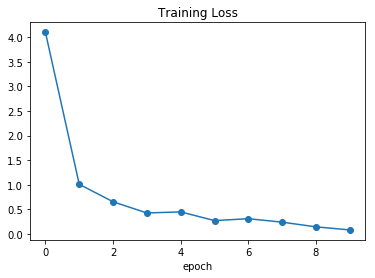

***** test accuracy: 0.743
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [32]:
# Clear old computation graphs
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/GPU:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [33]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
conv2 layer: (?, 32, 32, 64)
conv3 layer: (?, 16, 16, 96)
conv4 layer: (?, 8, 8, 128)
conv5 layer: (?, 4, 4, 160)
flat layer: (?, 2560)
fc6 layer: (?, 160)
fc7 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
